<a href="https://colab.research.google.com/github/yebenbenben/blog/blob/master/MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Why I wrote this article?
I was instroduced to probablistic inference model by Richard McElreath's fantastic book [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/) and was stunned by its flexibility to incoporate domain knowledge into model construction.

The biggist challenge of baysien inference is lack of analytical solution to calculate various statistical measures and to sample data from.

The MCMC was initially developed to  simulate the distribution of states for a system of idealized molecules. As the ecosystem developed over years, it provides numerous tools that make such tasks easier. 

There are many materials that covers such topic, here is a list of reference I used
- Bishop's [book](https://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738)
- Eric Xing from CMU has lectures in [10-708 PGM](https://youtube.com/playlist?list=PLoZgVqqHOumTqxIhcdcpOAJOOimrRCGZn)
- [Introduction to Markov Chain Monte Carlo](https://www.mcmchandbook.net/HandbookChapter1.pdf)

After learning all the theories, I decided to get my hands dirty and implement the common MCMC algorithm to reinforce my understandings. There are couple of pieces written in Metropolis Hastings and Hamiltonian MCMC, I borrow the some examples from them but using my own implementations, I will put them in reference.

# Why Markov Chain?
A couple of question I start to ask when I learn the MCMC sampling,
-  Why do we need Markov Chain for sampeling? 
-  Wouldn't that produce result that is not i.i.d?

To answer the first question, let's start from how we sample a arbitrary distribution $P(x)$ when closed-form pdf does not exist. The typical way is to use what is called **Rejection Sampling**, where $x$ is drawn from another distribution $Q(x)$ which we can sample and we accept $x$ with probabiliy $\frac{P(x)}{MQ(x)}$, where $M$ is a constant.

The problem with **Rejection Sampling** is that when proxy distribution $Q(x)$ is very different than true distribution $P(x)$, the acceptance rate is low (In high dimensional space, even if the $P(x)$ and $Q(x)$ are all multinominal, we can still experiencing high rejection).

**Markov Chain** is brought up as people sort to use stochastic proxy proposal distribution $Q(x'|x)$ which converge to the target distribution. There are certain criteria needed for the chain to converge to the target, but we will cover this later.

# Metropolis Hastings MCMC

Here is the description of the algorithem,
- Propose new sample $x'$ from $Q(\cdot|x)$ 
- Hasting Ratio : $R(x'|x) = \frac{P(x') Q(x|x')}{Q(x'|x)P(x)}$
- Metropolis Rejection : Accept $x'$ with probability $A(x'|x) = \min(1, R(x'|x))$, if rejected update the chain with original $x$

> The last step is often called Metropolis rejection. The name is supposed to remind one of “rejection sampling” in OMC, but this is a misleading analogy because in OMC rejection sampling is done repeatedly until some proposal is accepted (so it always produces a new value of the state). In contrast, one Metropolis–Hastings update makes one proposal y, which is the new state with probability A(y|x), but otherwise the new state the same as the old state x. Any attempt to make Metropolis rejection like OMC rejection, destroys the property that this update preserves the distribution with density h.

Below is my implementation using Gaussian proposal distribution. Some technical details:
- Use ```logpdf``` instead of ``pdf`` to avoid overflow or underflow for small or large numbers.
- $Q(x|x') = Q(x'|x)$ for Gaussian, we don't need to calculate $Q(\cdot)$ in implmentation.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, beta, bernoulli
from functools import partial

def mh_sampler(x0, lnprob_fn, prop_fn, iterations=100000):
    """
    Metropolis hastings sampler

    :param x0: Initial array of parameters.
    :param lnprob_fn: Function to compute log-posterior.
    :param prop_fn: Function to perform jumps and also return the factor for Q(x|x')/Q(x'|x)
    :param prop_fn_kwargs: Keyword arguments for proposal function
    :param iterations: Number of iterations to run sampler. Default=100000
    
    :returns: 
        (chain, acceptance, lnprob) tuple of parameter chain , acceptance rate 
        and log-posterior chain.
    """
    
    # number of dimensions
    ndim = len(x0)
    
    # initialize chain, acceptance rate and lnprob
    chain = np.zeros((iterations, ndim))
    lnprob = np.zeros(iterations)
    accept_rate = np.zeros(iterations)
    
    # first samples
    chain[0] = x0
    lnprob0 = lnprob_fn(x0)
    lnprob[0] = lnprob0
    
    # start loop
    naccept = 0
    for ii in range(1, iterations):
        # propose
        x_star, factor = prop_fn(x0)
        
        # draw random uniform number
        u = np.random.uniform(0, 1)
        
        # compute hastings ratio
        lnprob_star = lnprob_fn(x_star)
        H = np.exp(lnprob_star - lnprob0) * factor
        
        # accept/reject step (update acceptance counter)
        if u < H:
            x0 = x_star
            lnprob0 = lnprob_star
            naccept += 1
        
        # update chain
        chain[ii] = x0
        lnprob[ii] = lnprob0
        accept_rate[ii] = naccept / ii
    return chain, accept_rate, lnprob

In [ ]:
def gaussian_proposal(x, proposal_width=0.1): 
    # Draw x_star
    x_star = x + np.random.randn(len(x)) * proposal_width
    # proposal ratio factor is 1 since jump is symmetric
    # Simplify out symmetric proposal functions, Q(x'|x) == Q(x|x'), do not need to calculate Q(x'|x)
    qxx = 1
    return (x_star, qxx)

def plot_trace(chain, accept_rate, lnprob, **kwargs):
    """
    Plot Histogram and Evolution of chain, acceptrate, loglikilhood
    """
    plt.figure(figsize=(15, 8))
    ith_variable = kwargs.get('ith_variable', 0)
    # burn-in period
    burn = int(0.1 * chain.shape[0])
    num_var = chain.shape[1]
    nrow, ncol = num_var + 1, 2
    idx = 1
    for i in range(1, nrow):
      plt.subplot(nrow, ncol, idx)
      plt.xlabel('%s - variable' % i, fontsize=15)
      plt.hist(chain[burn:, i - 1], bins=50, density=True)
      if 'lines' in kwargs and 'curve' in kwargs:
        plt.plot(kwargs['lines'], kwargs['curve'])
      idx += 1

      plt.subplot(nrow, ncol, idx)
      plt.plot(chain[burn:, i - 1])
      plt.ylabel('%s - variable' % i, fontsize=15)
      plt.axhline(0.0, lw=2, color='C1')
      idx += 1

    plt.subplot(nrow, ncol, idx)
    plt.plot(lnprob[burn:])
    plt.ylabel('log-posterior', fontsize=15)
    idx += 1

    plt.subplot(nrow, ncol, idx)
    plt.plot(accept_rate[burn:])
    plt.ylabel('Acceptance Rate', fontsize=15)

    if 'proposal_width' in kwargs:
      plt.suptitle(r'$\sigma = {}$'.format(kwargs['proposal_width']), fontsize=15, y=1.02)
    plt.tight_layout()

### Diagnoising Efficiency And Convergence
If the Gaussian proposal distribution width are choosen too small $\sigma=0.01$, the trace of the chain will not be i.i.d and will look like a randomn walk, but the acceptance rate will be high. With a large width $\sigma=500$ the acceptance rate will be very low. And with $\sigma = 1$ we reach a reasonal convergence.

The optimal proposal width is $\sigma_{\text{jump}} = 2.38\frac{\sigma_{\text{posterior}}}{n_{\text{dim}}}$

### Drawback 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


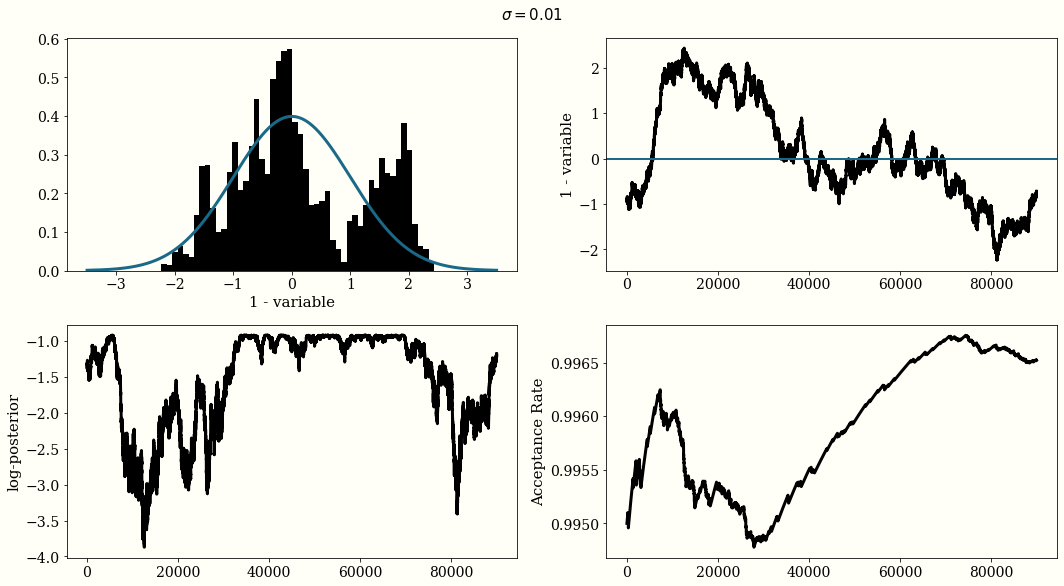

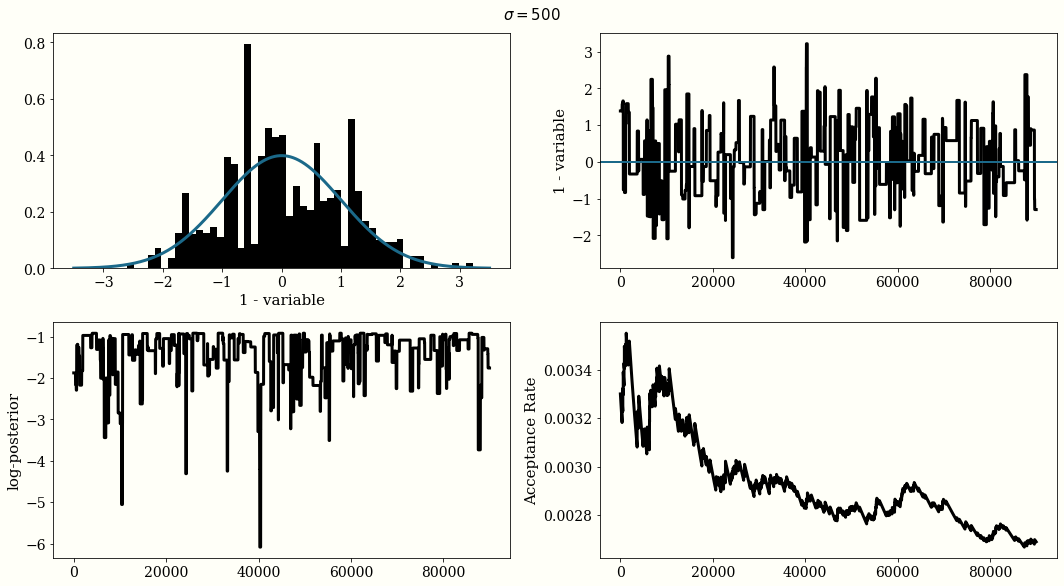

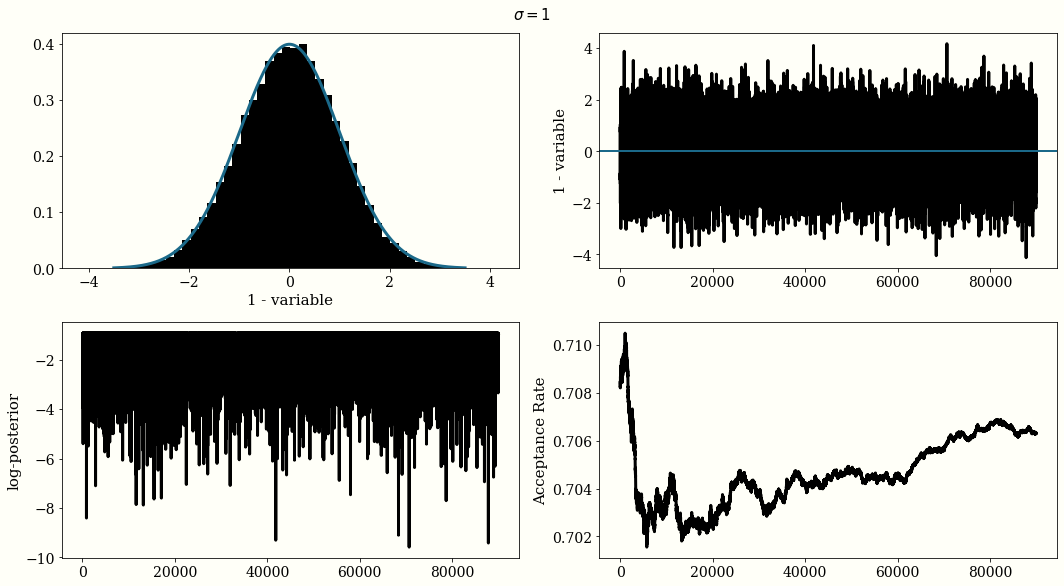

In [ ]:
iterations = 100_000
random.seed(10)
x0 = np.random.randn(1)
for proposal_width in [0.01, 500, 1]:
  chain, accept_rate, lnprob = mh_sampler(
      x0, 
      lnprob_fn=partial(norm.logpdf, loc=0, scale=1), 
      prop_fn=partial(gaussian_proposal, proposal_width=proposal_width),
      iterations=iterations
  )
  lines = np.linspace(-3.5, 3.5, 10_1000)
  curve = [norm.pdf(x=l, loc=0, scale=1) for l in lines]
  plot_trace(chain, accept_rate, lnprob, lines=lines, curve=curve, proposal_width=proposal_width)

### MH For Posterior Distribution Estimation
This section we discuss the application of using Metroplis Hastings in sampling posterior distribution. We use PyMC3 developr Thomas Wiecki's [example](https://twiecki.io/blog/2015/11/10/mcmc-sampling/).

In [ ]:
def generate_normal_dist_stochastic_mu(sample_size, mu_prior_mu, mu_prior_sd):
    """
    Generate sample data following below distribution
    mu ~ N(0, 1)
    x|mu ~ N(mu, 1)

    :param sample_size: int num of sample to be generated
    :param mu_prior_mu: float prior distribution mean for mu
    :param mu_prior_sd: float prior distribution std for mu
    """
    sample_mu = mu_prior_mu + mu_prior_sd * np.random.randn(sample_size) 
    data = sample_mu + np.random.randn(sample_size)
    return data

def calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd):
    """
    calculate posterior distribution given data
    mu ~ N(0, 1)
    x|mu ~ N(mu, 1)

    :param data: np.array sample data
    :param x: parameter x
    :param mu_prior_mu: float prior distribution mean for mu
    :param mu_prior_sd: float prior distribution std for mu
    """
    sigma = 1.
    n = len(data)
    mu_post = (mu_prior_mu / mu_prior_sd**2 + data.sum() / sigma**2) / (1. / mu_prior_sd**2 + n / sigma**2)
    sigma_post = (1. / mu_prior_sd**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

def post_lnporb(mu, data, mu_prior_mu, mu_prior_sd):
    """
    loglikelihood of posterior distribution of p(mu | data)

    :param mu: current parameter
    :param data: sample data
    :param mu_prior_mu: float prior distribution mean for mu
    :param mu_prior_sd: float prior distribution std for mu
    """
    log_likelihood = norm(mu, 1).logpdf(data).sum()
    log_prior_prob = norm(mu_prior_mu, mu_prior_sd).logpdf(mu)
    return log_likelihood + log_prior_prob

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


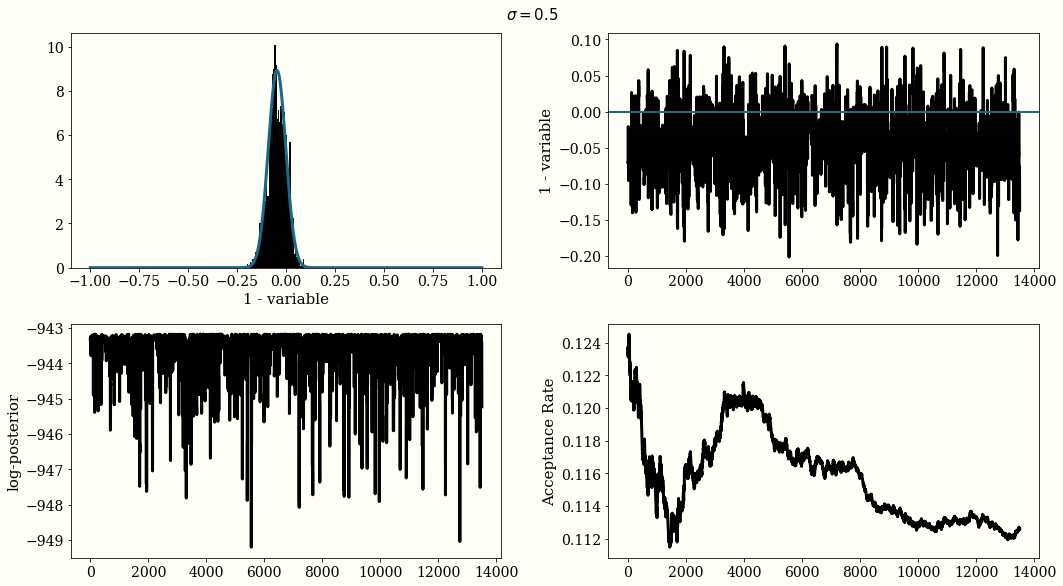

In [ ]:
# Generate Sample Data
mu_prior_mu = 0
mu_prior_sd = 1
random.seed(10)
data = generate_normal_dist_stochastic_mu(
        sample_size=500,
        mu_prior_mu=mu_prior_mu,
        mu_prior_sd=mu_prior_sd
      )

# Sampling
iterations = 15000
mu0 = np.random.randn(1)
proposal_width = .5
chain, accept_rate, lnprob = mh_sampler(
    mu0, 
    lnprob_fn=partial(post_lnporb, data=data, mu_prior_mu=mu_prior_mu, mu_prior_sd=mu_prior_sd), 
    prop_fn=partial(gaussian_proposal, proposal_width=proposal_width),
    iterations=iterations
)
lines = np.linspace(-1, 1, 500)
curve = calc_posterior_analytical(data, lines, mu_prior_mu, mu_prior_sd)
plot_trace(chain, accept_rate, lnprob, lines=lines, curve=curve, proposal_width=proposal_width)

### MH For Bayesian Logistic Regression
In this example of use MH to model bayesian logistic regression. The example is borrowed from [Jocob Moore's blog](https://colab.research.google.com/drive/1YQBSfS1Nb8a9TAMsV1RjWsiErWqXLbrj#scrollTo=ZF3foEKV8-r3)

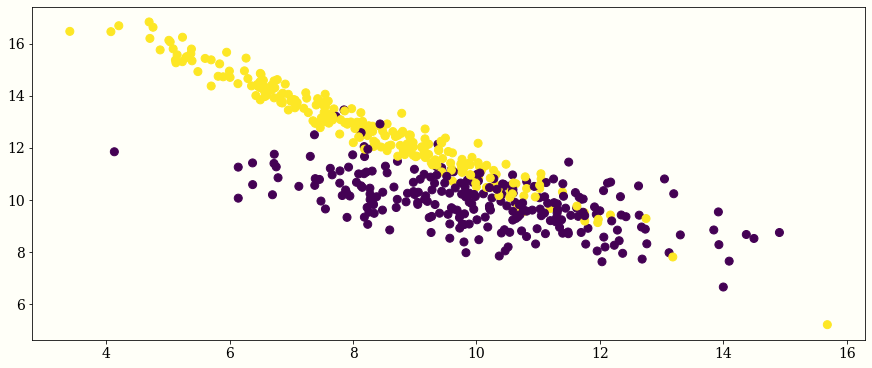

In [ ]:
# Generate Sample Data
from sklearn.datasets import make_classification
X,Y = make_classification(
    n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, 
    n_classes=2, n_clusters_per_class=1, weights=None, flip_y=0, class_sep=30.0,
    hypercube=False,shift=5.0, scale=2.0, shuffle=True,random_state=1
)
plt.scatter(x=X[:,0],y=X[:,1],c=Y)
newX = np.hstack((X, np.ones((len(X), 1))))

In [ ]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))
  
def post_lnporb_logistic(beta, x, y, beta_prior_mu, beta_prior_sd):
    """
    Loglikelihood of Posterior Distribution of Logistic Regression Parameter beta
    p = sigmoid(b1*x1 + b2*x2 + b0)
    
    :param beta: np.array [b1, b2, b0]
    :param x: feature space 2-D
    :param y: label 0 or 1
    :param beta_prior_mu: prior distribution mean of beta
    :param beta_prior_sd: prior distribution std of beta
    """
    curr_b1, curr_b2, curr_b0 = beta
    p = [sigmoid(curr_b1 * x1 + curr_b2 * x2 + curr_b0) for x1, x2 in x]
    log_likelihood = bernoulli.logpmf(y, p).sum()
    log_prior_prob = norm.logpdf(beta, beta_prior_mu, beta_prior_sd).sum()
    return log_likelihood + log_prior_prob

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


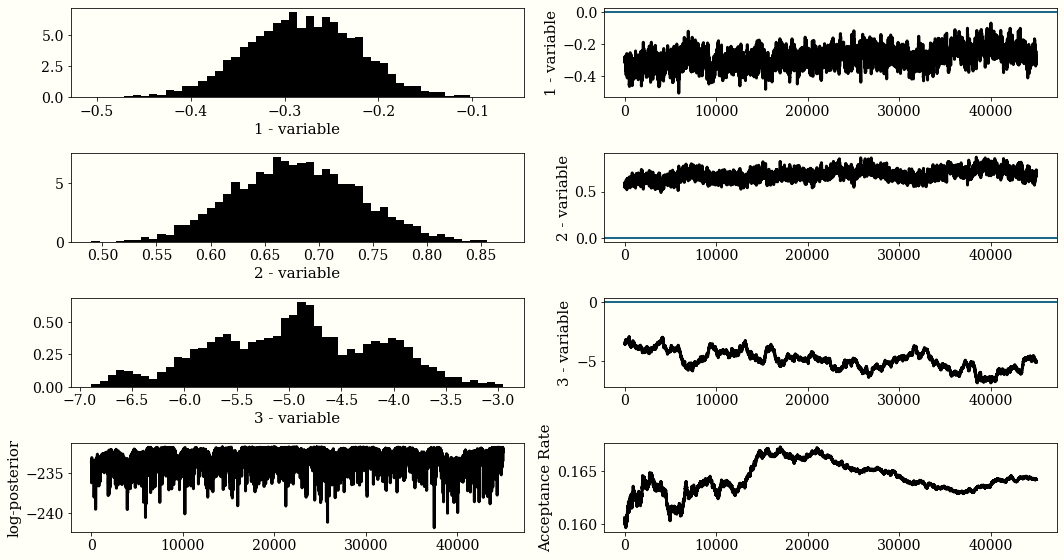

In [ ]:
# Sampling
iterations = 50_000
random.seed(10)
proposal_width = 0.05
beta0 = np.array([0., 0., 0.])
beta_prior_mu = np.array([0, 0, 0])
beta_prior_sd = np.array([1, 1, 1])

chain, accept_rate, lnprob = mh_sampler(
    beta0, 
    lnprob_fn=partial(post_lnporb_logistic, x=X, y=Y, beta_prior_mu=beta_prior_mu, beta_prior_sd=beta_prior_sd), 
    prop_fn=partial(gaussian_proposal, proposal_width=proposal_width),
    iterations=iterations
)
plot_trace(chain, accept_rate, lnprob)

# Calculate Average
burn = int(0.1 * chain.shape[0])
beta_mu = []
for i in range(chain.shape[1]):
    beta_mu.append(chain[burn:, i].mean())

# Hamiltonian Monte Carlo (HMC)
The Hamiltonian Monte Carlo is not as straight forward as Metropolis Hastings. I found below materical extremely helpful,
- [MCMC Using Hamiltonian Dynamics](https://www.mcmchandbook.net/HandbookChapter5.pdf)
- Colind Carroll's [blog](https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/)

- Colin Carroll's [minimc github](https://github.com/ColCarroll/minimc) (This has more material than the blog!)

- Michael Betancourt’s [“A Conceptual Introduction to Hamiltonian Monte Carlo“](https://arxiv.org/abs/1701.02434)

## Notation
Before we get started let's define our variables

- $t$ - time variable
- $q$ - position variable
- $p$ - momentum variable
- $U$ - potential energy
- $K$ - kinetic energy

## Phase Space and Hamilton's Equations
The total energy of the system is the sum of it's potential energy and kinetic energy, $H(p, q) = K(p, q) + U(q)$ where $H$ is the *Hamiltonian* function.

We then introduce canonical distribution [$\pi(q, p)$](https://en.wikipedia.org/wiki/Canonical_ensemble) which can be expressed as $$\pi(q, p) = e^{-H(q, p)}$$. The Hamiltonian can be written as $H(q, p) = -\log{\pi(q, p)}$. 

If we choose $\pi(q, p) = \pi(p)\pi(q)$, the above can be rewritten as $H(q, p) = -\log{\pi(p)} - \log{\pi(q)} = K(p) + U(q)$.

The system can be evovled according to *Hamilton's equations* with total energy unchange $H(p, q)$ unchanged,
$$
\begin{aligned}
\frac{dq}{dt} &= +\frac{\partial{H}}{\partial{p}} = \frac{\partial{K}}{\partial{p}}\\
\frac{dp}{dt} &= -\frac{\partial{H}}{\partial{q}} = - \frac{\partial{U}}{\partial{q}}\\
\end{aligned}
$$

**We noticed that the $\frac{\partial{U}}{\partial{q}}$ is the gradient of negative logrithm of the target density $\pi(q)$, that is the direction we try to explore our $q$ space.**

## Hamiltonian Markov Transition and Metropolis Hasting Criteria
- For a point on phase space, we sample from the conditional distribution over the momentum as $p \sim \pi(p)$.

- We explore $(q, p)$ by integration Hamilton's equation for some time. Then we return to the target parameter space by projecting away the momentum.

Technically, with no integration error $H$ will be constant after the integration. Therefore, the movement to $(p, q)$ with a different probability density is accomplished only by the first step in an HMC iterations. However, this replacement of $p$ can change the probability density by large amount so when we look at in terms of $q$ only, it produces a different potential energy.

Due to integration error, $H_0$ will not be the same as $H_1$ thus we add Metropolis Hasting Criteria to reject those projection that is not converging to $H_0$


### Hamilton Equation Integration Through LeapFrog
Colin's code is quite complete and therefore I borrowed some of his function and re-write the leap-frog and HMC sampler in a way that is more consistant, cuz his fast version of it is a bit confused for me to read.

In [ ]:
import autograd.numpy as np
from autograd import grad
from autograd.scipy.special import logsumexp
from scipy.stats import norm

def leapfrog(q0, p0, dVdq, path_len, step_size):
    """
    Leapfrog integrator for Hamiltonian Monte Carlo.
    :param q : np.float  Initial position
    :param p : np.float  Initial momentum
    :param dVdq : callable Gradient of the potential function
    :param path_len : float How long to integrate for
    :param step_size : float How long each integration step should be

    :return:
        (q, p): np.float, np.float New position and momentum
    """
    q, p = np.copy(q0), np.copy(p0)

    p -= step_size * dVdq(q) / 2 # Half Step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p
        p -= step_size * dVdq(q)
    q += step_size * p
    q -= step_size * dVdq(q) / 2 # Half Step

    # moment flip for technicial reason
    return q, -p

In [ ]:
def HMC_Sampler(
        n_samples, 
        negative_log_prob, 
        initial_position, 
        path_len=1, 
        step_size=0.1
    ):
    """
    Run Hamiltonian Monte Carlo sampling.

    :param n_samples : int Number of samples to return
    :param negative_log_prob : callable 
        The negative log probability to sample from == Potential Function
    :param initial_position : np.array A place to start sampling from.
    :param path_len : float How long each integration path is. 
        Smaller is faster and more correlated.
    :param step_size : float How long each integration step is. 
        Smaller is slower and more accurate.

    :return: 
        np.array Array of length `n_samples`.
    """
    # If initial_position is a 10d vector and n_samples is 100, we want
    # 100 x 10 momentum draws. We can do this in one call to momentum.rvs, and
    # iterate over rows
    initial_position = np.array(initial_position)
    size = (n_samples,) + initial_position.shape[:1]
    chains = [initial_position]
    V0 = negative_log_prob(chains[-1])

    # autograd magic
    dVdq = grad(negative_log_prob)

    # sample momentum
    momentum = norm(0, 1)
    for p0 in momentum.rvs(size=size):
        # Integrate over our path to get a new position and momentum
        q1, p1 = leapfrog(chains[-1], p0, dVdq, path_len, step_size)
        V1 = negative_log_prob(q1)
        
        # Check Metropolis acceptance criterion
        H0 = -momentum.logpdf(p0).sum() + V0
        H1 = -momentum.logpdf(p1).sum() + V1
        p_accept = min(1, np.exp(H0 - H1))
        if np.random.rand() < p_accept:
            V0 = V1
            chains.append(np.copy(q1))
        else:
            chains.append(np.copy(chains[-1]))
    return np.array(chains[1:])

## Applications

In [ ]:
def neg_log_normal(mu, sigma):
    """
    logp(x | mu, sigma) = 0.5 * log(2π) + log(σ) + 0.5 * ((x - μ)/σ)^2
    """

    def logp(x):
        return 0.5 * (np.log(2 * np.pi * sigma * sigma) + ((x - mu) / sigma) ** 2)
    return logp

def neg_log_mvnormal(mu, sigma):
    """
    Use a Cholesky decomposition for more careful work.
    """

    def logp(x):
        k = mu.shape[0]
        return (
            k * np.log(2 * np.pi)
            + np.log(np.linalg.det(sigma))
            + np.dot(np.dot((x - mu).T, np.linalg.inv(sigma)), x - mu)
        ) * 0.5
    return logp

def mixture(neg_log_probs, probs):
    """
    Log probability of a mixture of probabilities.
    neg_log_probs should be an iterator of negative log probabilities
    probs should be an iterator of floats of the same length that sums to 1-ish
    """
    probs = np.array(probs) / np.sum(probs)
    assert len(neg_log_probs) == probs.shape[0]

    def logp(x):
        return -logsumexp(np.log(probs) - np.array([logp(x) for logp in neg_log_probs]))
    return logp

Text(0.5, 0.98, '1D Gaussian')

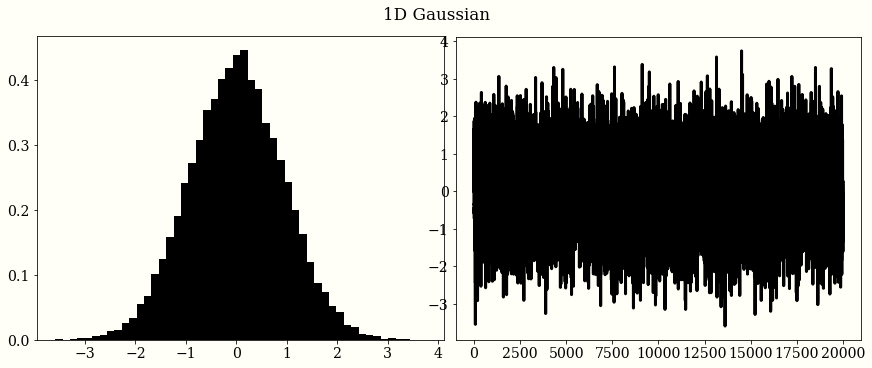

In [ ]:
# 1D Gaussian
mu = 0
sigma = 1
initial_position = 0.
chains = HMC_Sampler(
    n_samples=20_000, 
    negative_log_prob=neg_log_normal(mu, sigma),
    initial_position=initial_position,
)

# plot
plt.subplot(1, 2, 1)
plt.hist(chains, bins=50, density=True)
plt.subplot(1, 2, 2)
plt.plot(chains)
plt.suptitle('1D Gaussian')

Text(0.5, 1.0, 'Multivariate Gaussians')

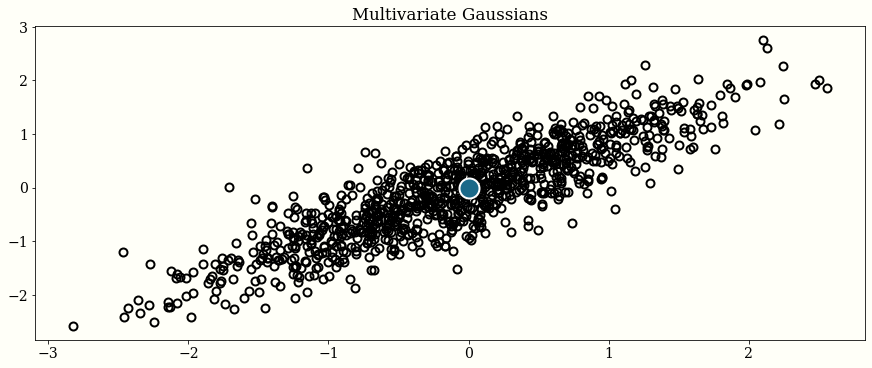

In [ ]:
# 2D Gaussian
mu = np.zeros(2)
cov = np.array([[1.0, 0.8], [0.8, 1.0]])
initial_position = np.zeros(2)
chains = HMC_Sampler(
    n_samples=1000, 
    negative_log_prob=neg_log_mvnormal(mu, cov),
    initial_position=initial_position,
)

# plot
fig, ax = plt.subplots()
ax.plot(chains[:, 0], chains[:, 1], "o")
ax.plot(mu[0], mu[1], "o", color="w", ms=20, mfc="C1")
ax.set_title("Multivariate Gaussians")

Text(0.5, 1.0, 'Multivariate Mixtures')

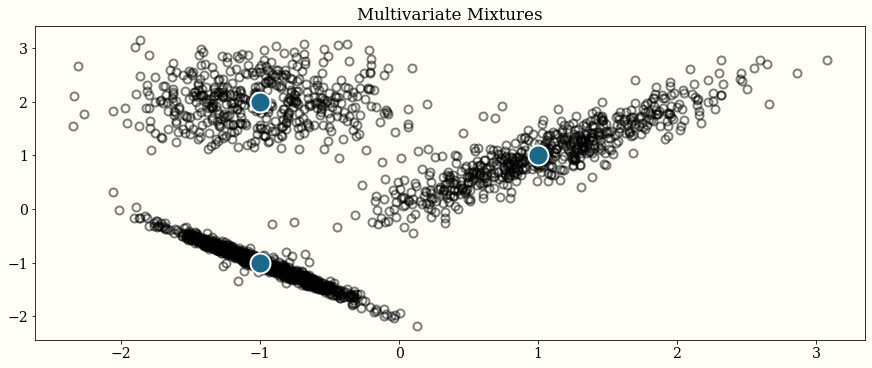

In [ ]:
# Mixture
mu1 = np.ones(2)
cov1 = 0.5 * np.array([[1.0, 0.7],
                       [0.7, 1.0]])
mu2 = -np.ones(2)
cov2 = 0.2 * np.array([[1.0, -0.6],
                       [-0.6, 1.0]])

mu3 = np.array([-1.0, 2.0])
cov3 = 0.3 * np.eye(2)

neg_log_p = mixture(
    [
        neg_log_mvnormal(mu1, cov1),
        neg_log_mvnormal(mu2, cov2),
        neg_log_mvnormal(mu3, cov3),
    ],
    [0.3, 0.3, 0.4],
)
chains = HMC_Sampler(2000, neg_log_p, np.zeros(2))

# plot
means = np.array([mu1, mu2, mu3])
plt.plot(chains[:, 0], chains[:, 1], "o", alpha=0.5)
plt.plot(means[:, 0], means[:, 1], "o", color="w", ms=20, mfc="C1")
plt.title("Multivariate Mixtures")

### HMC For Bayesian Logistic Regression

### Metropolis Hastings vs. Hamiltanion Monte Carlo

### Limitation
One known limitation is HMC can't handel descrete variables since we can't take gradient, but we can combine it with other MCMC updates, for example update subset of the variables using HMC and use Gibbis sample for example to update othe other subset.

